### TODO: 

1. 
    - Kilder andre steder?
2. 
    - AI avsnitt, markere AI bruk
3. 
    - Ska vi bruke test-case 1 noe sted?
4. 
    - Ha med speed-up? Hvordan presentere?
5. 
    - Jeg la inn plottefunksjonene i main for å gjøre det lettere å redigere dem. Disse bør flyttes til plotting.py før levering.
6.
    - Chat rettskrivning
     

# TMA4205 Project - Optical flow

**Authors:** Henning Hegstad, Per Øygard Ryjord 

### Use of AI

In the project we have used openAIs chatGPT and copilot to write plotting functions, debug code (especially indices), spelling and understanding the project. 


## Introduction

In this project, we have tested our implementation of the conjugate gradient method (CG), V-cycle and preconditioned conjugate gradient (PCG) to solve the optical flow (OF) problem. To test, both synthetic and real-life images was used. The project description can be found in `project.pdf`

## Problem 1

### Rewriting as a standard linear system

The solutions $u$ and $v$ are $n \times m$ matrices, but our methods are built for solutions on vector form. Thus we will transform $u$ and $v$ into $nm$-dimensional vectors. Furthermore, we want to have them on the form of one solution, so we will concatenate them into one vector of size $2nm$.

Doing the same with the right hand sides gives us a system on the form
\begin{equation}
    \begin{pmatrix}
        A_1 & A_2\\
        A_3 & A_4
    \end{pmatrix}
    \begin{pmatrix}
        u\\v
    \end{pmatrix}
    =
    \begin{pmatrix}
        - \partial_t I \partial_x I\\
        - \partial_t I \partial_x I
    \end{pmatrix},
\end{equation}
where the $A_i$'s are matrices of size $nm \times nm$.

Now using the reindexation $ij \to k$, we get the equations
\begin{align}
    (\partial_x I)^2_k u_k + (\partial_y I)_k(\partial_x I)_k v_k - \lambda(A_{h_0}u)_k
    &=
    -(\partial_t I)_k (\partial_x I)_k
    \tag{2}
    \\
    (\partial_y I)^2_k v_k + (\partial_y I)_k(\partial_x I)_k u_k - \lambda(A_{h_0}v)_k
    &=
    -(\partial_t I)_k (\partial_y I)_k
    \tag{3}
\end{align}

Thus
\begin{equation}
    \tag{4}
    \begin{pmatrix}
        A_1 & A_2\\
        A_3 & A_4
    \end{pmatrix}
    =
    \begin{pmatrix}
        D_{xx} - \lambda A_{h_0} & D_{xy} \\
        D_{xy} & D_{yy} - \lambda A_{h_0}
    \end{pmatrix},
\end{equation}
where $D_{xx}$, $D_{xy}$ and $D_{yy}$ are diagonal matrices of with elements $(\partial_x I)_k^2$ and $(\partial_x I)_k(\partial_y I)_k$ and $(\partial_y I)_k^2$ respectively.


We want to look at the properties of the system, in particular its well-posedness. In particular, we will show the system is symmetric positive definite (SPD).

#### **Symmetric**
Since $D_{xx}, D_{yy}, D_{xy}$ and $A_{h_0}$ are symmetric, the system is symmetric.


#### **Positive definite**
To show positive definiteness, we can split the matrix into two matrices
\begin{align*}
    \begin{pmatrix}
        D_{xx} - \lambda A_{h_0} & D_{xy} \\
        D_{xy} & D_{yy} - \lambda A_{h_0}
    \end{pmatrix}
    =
    \begin{pmatrix}
        D_{xx} & D_{xy} \\
        D_{xy} & D_{yy}
    \end{pmatrix}
    +
    \begin{pmatrix}
        - \lambda A_{h_0} & 0 \\
        0 & - \lambda A_{h_0}
    \end{pmatrix}.
\end{align*}

For the second matrix, note that $|4\lambda| \geq |\lambda| + |\lambda| + |\lambda| + |\lambda|$, thus its weakly diagonally dominant. The first row only has three elements, so the diagonal dominates strictly. Since every row is connected to both the previous and the next, we see that the matrix is strongly connected and thus irreducibly diagonally dominant. As a consequence, it is invertible, and all eigenvalues are non-zero. Now, since all elements on the diagonal are positive and the is matrix weakly diagonally dominant, we have that all eigenvalues are non-negative by Gershgorin's theorem. Thus the matrix is positive semi-definite. But, the eigenvalues are non-zero, so we can actually see that the matrix is (strictly) positive-definite.

Now, for the first matrix, we look at
\begin{align*}
    \begin{pmatrix}
        u^T & v^T
    \end{pmatrix}
    \begin{pmatrix}
        D_{xx} & D_{xy}\\
        D_{xy} & D_{yy}
    \end{pmatrix}
    \begin{pmatrix}
        u\\
        v
    \end{pmatrix}
    =
    \begin{pmatrix}
        u^T & v^T
    \end{pmatrix}
    \begin{pmatrix}
        D_{xx}u + D_{xy}v\\
        D_{xy}u + D_{yy}v
    \end{pmatrix}
    =
    u^T D_{xx} u + u^T D_{xy} v + v^T D_{xy} u + v^T D_{yy} v
\end{align*}

Writing the inner products as sums, we get
\begin{align*}
    u^T D_{xx} u + u^T D_{xy} v + v^T D_{xy} u + v^T D_{yy} v
    &=
    \sum_k ( (\partial_x I)_k^2 u_k^2 )
    + 2 \sum_k ( (\partial_x I)_k (\partial_y I)_k v_k u_k )
    + \sum_k ( (\partial_y I)_k^2 v_k^2 )
    \\
    &=
    \sum_k \Bigl( (\partial_x I_k u_k)^2 + 2 (\partial_x I_k u_k) (\partial_y I_k v_k) + (\partial_y I_k v_k)^2  \Bigr) 
    \\
    &=
    \sum_k \Bigl( (\partial_x I_k u_k + \partial_y I_k v_k)^2 \Bigr).
\end{align*}

Since the sum is over the square of real numbers, we see that it is non-negative, and thus the first matrix is positive semi-definite.

Since the first matrix is positive semi-definite, and the second matrix is positive definite, we have that their sum is positive definite, and thus our system is positive definite.

#### **Diagonally dominant**
Because of the $D_{xx}, D_{yy}$ and $D_{xy}$ matrices, we cannot generally say if the system is weakly diagonally dominant, since this depends on the image itself. However, we can conclude that the system is not diagonally dominant, which we will show with a short proof.

For the system to be (strictly) diagonally dominant, we would need both $|(\partial_x I)^2_{ij} + 4\lambda| = |(\partial_x I)^2_{ij}| + 4\lambda > |(\partial_x I)_{ij} (\partial_y I)_{ij}| + 4\lambda$ and $|(\partial_y I)^2_{ij}| + 4\lambda > |(\partial_x I)_{ij} (\partial_y I)_{ij}| + 4\lambda$ at each point $ij$ such that row $i$ contains 4 negative Laplacian terms. We can remove $4\lambda$ from both sides. Further dividing both inequalities by their common factors we get the inequalities $|\partial_x I_{ij}| > |\partial_y I_{ij}|$ and $|\partial_y I_{ij}| > |\partial_x I_{ij}|$, which is a contradiction.
Thus we can see that the system is not diagonally dominant, though we cannot say if it is weakly diagonally dominant.

For the system to be irreducibly row diagonally dominant, we would need $|\partial_x I_{ij}| = |\partial_y I_{ij}|$. In this case, note that the first row of the system only contains 2 negative Laplacian terms, so the diagonal is dominant on this row. Moreover, the Laplacian operator ensures that each row is connected to the next and to the previous, so the system is strongly connected. Thus, in the case of an image where $|\partial_x I_{ij}| = |\partial_y I_{ij}|$ at each point, we would have a irreducibly row diagonally dominant matrix.

#### **Convergence**
If we have that the x-derivative and y- of the image are equal at each point, then the system is irreducibly row diagonally dominant, and we get that the Jacobi iterations converge for any initial guess. This is however rarely the case, and the system is also never diagonally dominant, so we don't expect Jacobi to converge.

Even though the system is rarely irreducibly row diagonally dominant, and never diagonally dominant, we do have that it is symmetric positive definite. As a result, the SOR algorithm converges for $0<\omega<2$ [Saad, theorem 4.10]. Since Gauss-Seidel is SOR with $\omega=1$, we have that the algorithm will converge for our system.

For conjugate gradient, we have that the algorithm only works for SPD matrices, which we do have [Saad, 6.7]. Moreover, we have the error estimate
\begin{equation*}
    \|x_\ast-x_m\|_A \leq 2\left[ \frac{\sqrt{\kappa}-1}{\sqrt{\kappa}+1} \right]^m \|x_\ast-x_0\|_A,
\end{equation*}
where $\kappa = |\lambda_{\mathrm{max}}/\lambda_{\mathrm{min}}|$ is the spectral condition number [Saad, equation 6.128]. Noting that $0<\kappa$, we get that $(\sqrt{\kappa}-1)/(\sqrt{\kappa}+1) \in (0,1)$, and thus we see that the error goes to zero as $m$ increases. We conclude that the method converges.

# Problem 2 - CG

Since we showed the system is SPD, a common way to solve such system is the Conjugate Gradient (CG) method, as described in Saad, chapter 6.7, algorithm 6.18. To test the implementation, we use the test-images shown below, with size $2^k \times 2^k$, with $k=9$. 

In [1]:
%reload_ext autoreload
%autoreload 2
from Testcode.utils import *
from Code.V_cycle import *
from Code.PCG import *
from Code.preprocess import *
from Code.plotting import *

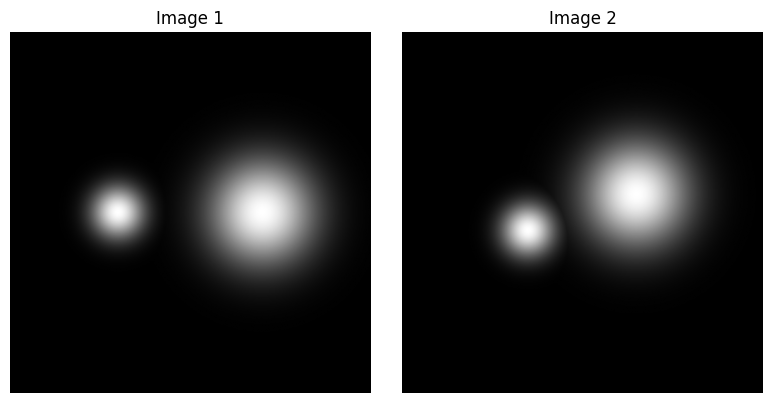

In [2]:
# Plotting below made by LLM
image1, image2 = generate_test_image(2**9, testcase=2)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(image1, cmap='gray')
axes[0].set_title("Image 1")
axes[0].axis('off')

axes[1].imshow(image2, cmap='gray')
axes[1].set_title("Image 2")
axes[1].axis('off')

plt.tight_layout()
plt.show()


We run the CG algorrithm for different image sizes $k=6,7,8,9$, and $\lambda = 4^{k-4}$

In [3]:
import time

k_list = [6, 7, 8, 9]
cg_results = {}

for k in k_list:
    image1, image2 = generate_test_image(2**k, testcase=2)
    Ix, Iy, rhsu, rhsv = preprocess_images(image1, image2, sigma=0)
    u0 = np.zeros_like(Ix)
    v0 = np.zeros_like(Ix)
    reg = 4**(k - 4)

    start_time = time.time()
    u_cg, v_cg, cg_iter, r_list = OF_cg(u0, v0, Ix, Iy, reg, rhsu, rhsv,
                                tol=1e-8, maxit=2000)
    elapsed_time = time.time() - start_time

    cg_results[k] = {
        "u": u_cg,
        "v": v_cg,
        "iterations": cg_iter,
        "time": elapsed_time,
        "residuals": r_list
    }



In [4]:
import matplotlib.pyplot as plt
import numpy as np

def plot_cg_results(cg_results, k_list, mycolorwheel, mycomputeColor, title_prefix="CG"):
    """
    Plot optical flow fields and residual convergence for CG results.
    """

    # --- Combined flow field figure with color wheel ---
    fig, axes = plt.subplots(1, len(k_list) + 1, figsize=(18, 4))
    colorwheel = mycolorwheel(200)

    # 🌟 Add a super title for the entire figure
    fig.suptitle(f"{title_prefix} Optical Flow Results", fontsize=16, fontweight="bold", y=1.02)

    for ax, k in zip(axes[:-1], k_list):
        u = cg_results[k]["u"]
        v = cg_results[k]["v"]
        n_iter = cg_results[k]["iterations"]
        t = cg_results[k]["time"]

        img_rgb = mycomputeColor(u, v)
        ax.imshow(img_rgb)
        ax.set_title(
            f"$2^{k} \\times 2^{k}$",
            fontsize=10
        )
        ax.axis("off")

    # Color wheel inset (last slot)
    ax_cw = axes[-1]
    alpha = np.any(colorwheel != 1, axis=2).astype(float)
    ax_cw.imshow(colorwheel, alpha=alpha)
    ax_cw.axis("off")
    ax_cw.set_title("Color wheel", fontsize=10)

    plt.tight_layout(rect=[0, 0, 1, 0.95])  # leave space for suptitle
    plt.show()

    # --- Residual convergence plot ---
    plt.figure(figsize=(8, 5))
    for k in k_list:
        t = cg_results[k]["time"]
        r_list = np.array(cg_results[k]["residuals"])
        plt.semilogy(r_list, label=f"$2^{k} \\times 2^{k}$ ({t:.2f}s)")

    plt.xlabel("Iteration")
    plt.ylabel("Relative residual norm")
    plt.title(f"{title_prefix} Convergence for Different Grid Sizes")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title="Grid size")
    plt.tight_layout()
    plt.show()


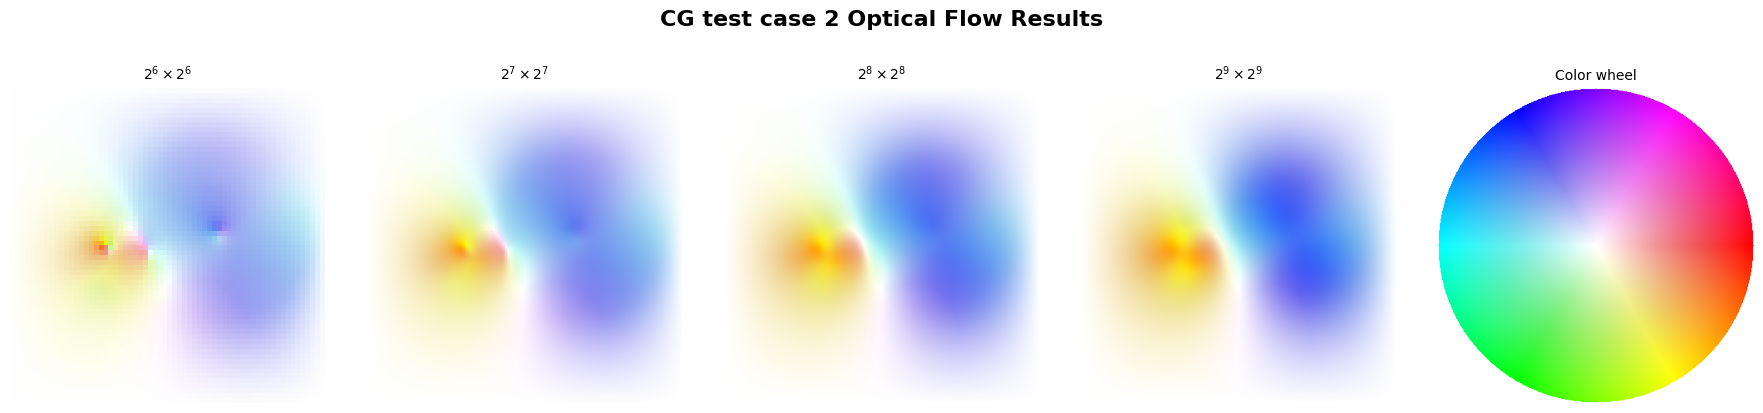

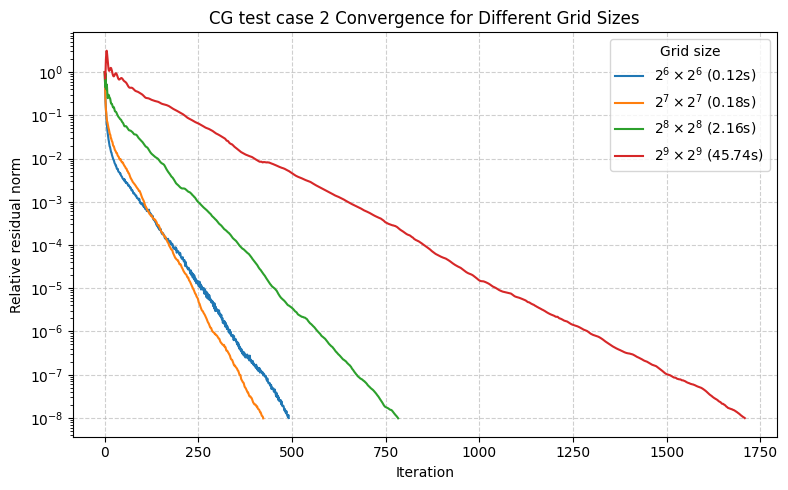

In [5]:
plot_cg_results(
    cg_results=cg_results,
    k_list=k_list,
    mycolorwheel=mycolorwheel,
    mycomputeColor=mycomputeColor,
    title_prefix="CG test case 2"
)


The color of in the images in the first plot are the corresponding direction and intesity of the color in the colorwheel. We observe what we expect, the left ball moves down to the right, and the right ball ball moves up and to the left.

The second plot showns the convergence of the residuals. $k=6,7$ shows similar convergence to each other, while $k=8$ shows a little slower, and $k=9$ very slow convergence. Slower convergence is expected for larger images, since the the dimension is larger.

We test the method for two real images, taken from the project description, shown below.


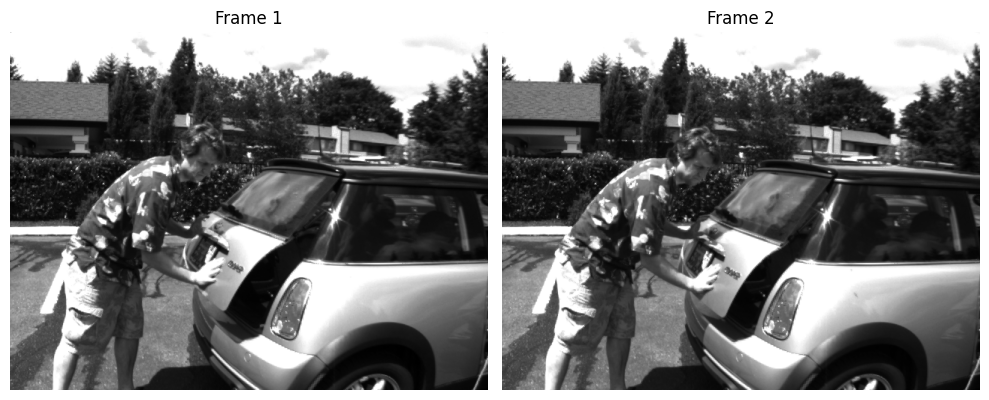

In [6]:
import matplotlib.pyplot as plt
# Load images
I1 = plt.imread('Images/frame10.png')
I2 = plt.imread('Images/frame11.png')

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(I1, cmap='gray')
axes[0].set_title("Frame 1")
axes[0].axis('off')

axes[1].imshow(I2, cmap='gray')
axes[1].set_title("Frame 2")
axes[1].axis('off')

plt.tight_layout()
plt.show()


We run the algorithm for different regularization parameters $\lambda$. Since $\lambda$ is a regularization parameter that weighs the importance of smoothing out the solution, a lower value of $\lambda$ will give a more detailed solution of the optical flow, while a larger value gives a more smooth solution. A more detailed solution might not be better, and neither will a very smooth solution. It is difficult to say what will give a most accurate solution for our optical flow problem, since the value of $\lambda$ should be dependent on how fast we expect the optical flow to change. If there also is noise in our image, then a smaller value of $\lambda$ might give a less useful solution, as the more detailed solution will be very dependent on the noise. This is why we will also denoise our image using a Gaussian filter. We chose $\sigma=0.5$ as it seemed to give a good balance between keeping the details of the image while still removing the noise.

In [7]:
reg_list = [0.5, 1, 10, 1000]
sigma = 0.5

Ix, Iy, rhsu, rhsv = preprocess_images(I1, I2, sigma=sigma)
u0 = np.zeros_like(Ix)
v0 = np.zeros_like(Ix)

cg_results_image = {}

for reg in reg_list:
    start_time = time.time()
    u_cg, v_cg, cg_iter, r_list = OF_cg(
        u0, v0, Ix, Iy, reg, rhsu, rhsv,
        tol=1e-8, maxit=5000
    )
    elapsed_time = time.time() - start_time
    cg_results_image[reg] = {
        "u": u_cg,
        "v": v_cg,
        "iters": cg_iter,
        "residuals": np.array(r_list),
        "time": elapsed_time
    }

In [8]:
def plot_flow_and_residuals_cg(cg_results, reg_list, I1, mycolorwheel, mycomputeColor,
                            title_prefix="CG", suptitle="Optical Flow Results"):
    """
    Plot optical flow fields and residual convergence curves for CG or PCG results.

    Parameters
    ----------
    cg_results : dict
        Dictionary with keys = regularization parameters, containing:
            - "u", "v": flow components
            - "iters": number of iterations
            - "time": total computation time
            - "residuals": list/array of relative residual norms
    reg_list : list
        List of regularization parameters (λ values).
    I1 : np.ndarray
        First input image (grayscale or RGB).
    mycolorwheel : function
        Function to generate color wheel visualization.
    mycomputeColor : function
        Function to convert (u, v) flow fields into an RGB image.
    title_prefix : str, optional
        Prefix for plot titles (default "CG").
    suptitle : str, optional
        Overall figure title.
    """

    # --- Plot flow fields ---
    fig, axes = plt.subplots(1, len(reg_list), figsize=(15, 5))
    colorwheel = mycolorwheel(100)
    alpha = np.any(colorwheel != 1, axis=2).astype(float)

    for ax, reg in zip(axes, reg_list):
        u = cg_results[reg]["u"]
        v = cg_results[reg]["v"]
        img_rgb = mycomputeColor(u, v)
        iters = cg_results[reg]["iters"]
        t = cg_results[reg]["time"]

        ax.imshow(I1, cmap='gray')
        ax.imshow(img_rgb, alpha=0.6)
        ax.set_title(f" $\\lambda$={reg}")
        ax.axis('off')

        # Add color wheel inset to first plot only
        if reg == reg_list[0]:
            inset = ax.inset_axes([0.73, 0.05, 0.25, 0.25])
            inset.imshow(colorwheel, alpha=alpha)
            inset.axis('off')

    # plt.suptitle(f"{suptitle} ({title_prefix})", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()

    # --- Plot residual convergence curves ---
    plt.figure(figsize=(7, 5))
    for reg in reg_list:
        t = cg_results[reg]["time"]
        r = np.array(cg_results[reg]["residuals"])
        plt.semilogy(r, lw=2, label=f"$\\lambda$={reg} ({t:.2f}s)")

    plt.xlabel("Iteration")
    plt.ylabel("Relative residual norm")
    plt.title(f"Residual Convergence ({title_prefix})")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

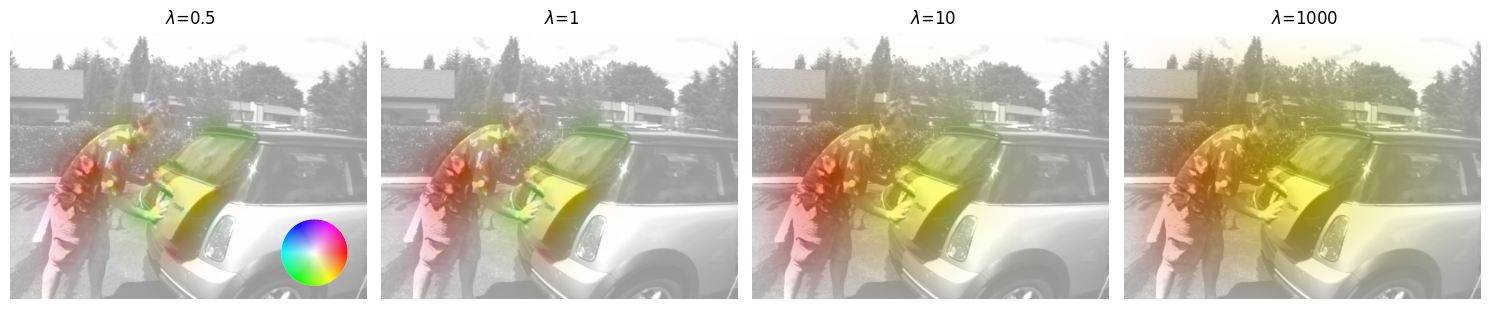

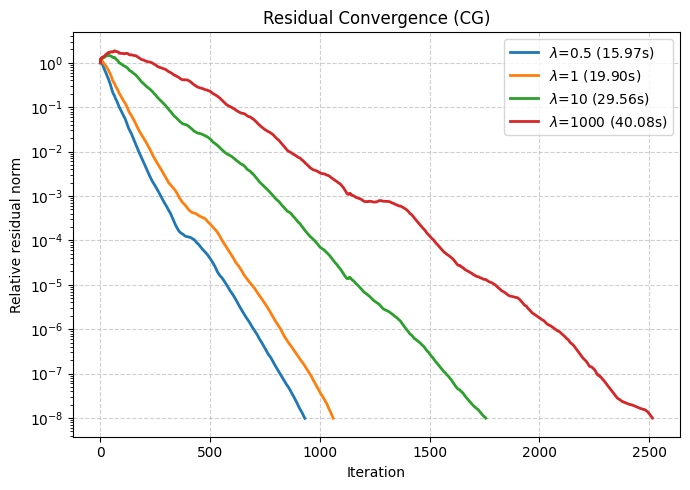

In [9]:
plot_flow_and_residuals_cg(
    cg_results_image,
    reg_list=reg_list,
    I1=I1,
    mycolorwheel=mycolorwheel,
    mycomputeColor=mycomputeColor,
)


For $\lambda=0.5,1$, we observe a detailed representation of the OF, however the method picks up some details which seem strange. For example, the hand is green, which implies it goes down to the left, which is not what is observed from the images. For $\lambda=10,100$, we force the solution to be to be smoother, which washes out some details, but may give a more accurate solutions.

We observe that lower $\lambda$ gives faster convergence than larger $\lambda$.

# Problem 3 - V-cycle

To speed up the iterative solver we will use a multigrid solver, namely the V-cycle algorithm described in Saad 13.4.3, algorithm 13.3. As smoother we will use Red-Black Gauss-Seidel. Since $u_{ij}$ is only dependent on $v_{ij}$, $u_{i+1,j}$, $u_{i-1,j}$, $u_{i, j-1}$ and $u_{i, j+1}$, and vice versa for $v_{ij}$, we choose the red nodes as the nodes where $i+j (\mod 2) = 0$ for $u$, and $i+j (\mod 2) = 1$ for $v$. This way the red nodes are independent of each other, and the black nodes are independent of each other.

To update $u_{ij}$, we use the linear system elementwise. Note that
\begin{align*}
    (\partial_x I)_{ij}^2 u_{ij} + (\partial_x I)_{ij} (\partial_y I)_{ij} v_{ij} - \lambda A_{h_0} u_{ij} = b_u,
\end{align*}
where $b_u = -(\partial_t I)_{ij} (\partial_x I)_{ij}$.

As a result we update
\begin{align*}
    u_{ij} = \frac{b_u + \lambda(u_{i+1,j} + u_{i-1,j} + u_{i,j-1} + u_{i,j+1}) - (\partial_x I)_{ij} (\partial_y I)_{ij} v_{ij} }{ (\partial_x I)_{ij}^2 + 4\lambda}.
\end{align*}

Similarly for $v_{ij}$, we have
\begin{align*}
    v_{ij} = \frac{b_v + \lambda(v_{i+1,j} + v_{i-1,j} + v_{i,j-1} + v_{i,j+1}) - (\partial_x I)_{ij} (\partial_y I)_{ij} u_{ij} }{ (\partial_y I)_{ij}^2 + 4\lambda},
\end{align*}
where $b_v = -(\partial_t I)_{ij} (\partial_y I)_{ij}$.

Thus we can update iteratively using slicing, and then filter out based on a mask to update only the red or black nodes.

Since V-cycle is just one iteration of a multigrid method, we can use it iteratively to further reduce the residual. We will use a maximum of 25 iterations of the V-cycle in our tests.

We run the iterative V-cycle for different $k$, max levels and numbers of smoothing steps. 

In [10]:
import time
import numpy as np

max_level_list = [1, 2, 3]
s_list = [1, 3, 5]
VC_results = {}

for k in k_list:
    image1, image2 = generate_test_image(2**k, testcase=2)
    Ix, Iy, rhsu, rhsv = preprocess_images(image1, image2, sigma=0)
    u0 = np.zeros_like(Ix)
    v0 = np.zeros_like(Ix)
    reg = 4**(k - 4)

    VC_results[k] = {}

    for max_level in max_level_list:
        VC_results[k][max_level] = {}

        for s in s_list:
            start_time = time.time()
            
            u_VC, v_VC, res_list = V_cycle_iterative(u0, v0, Ix, Iy, reg, rhsu, rhsv,
                              s1=s, s2=s, max_level=max_level,max_iter=25)

            elapsed_time = time.time() - start_time

            u_cg = cg_results[k]["u"]
            v_cg = cg_results[k]["v"]

            VC_results[k][max_level][s] = {
                "u": u_VC,
                "v": v_VC,
                "iterations": len(res_list),
                "time": elapsed_time,
                "residuals": res_list
            }


In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_VC_results(VC_results,cg_results, k_list, mycolorwheel=None, mycomputeColor=None, title_prefix="V-Cycle"):
    """
    Plot V-cycle residual convergence for multiple grid sizes.

    Parameters
    ----------
    VC_results : dict
        Nested dictionary with structure:
            VC_results[k][max_level][s] = {
                'u': np.array,
                'v': np.array,
                'time': float,
                'residuals': list or np.array
            }
    k_list : list
        List of grid size exponents (e.g. [4, 5, 6]).
    mycolorwheel : function, optional
        Included for API consistency with CG plotting functions.
    mycomputeColor : function, optional
        Included for API consistency with CG plotting functions.
    title_prefix : str, optional
        Prefix for plot titles (default: "V-Cycle").
    """

    nplots = len(k_list)
    nrows, ncols = 2, 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10))
    axes = axes.ravel()

    for ax, k in zip(axes, k_list):
        for max_level in sorted(VC_results[k].keys()):
            for s in sorted(VC_results[k][max_level].keys()):
                data = VC_results[k][max_level][s]
                cg_data = cg_results[k]
                res_list = np.array(data["residuals"])
                t = data["time"]
                cg_t = cg_data["time"]
                ax.semilogy(
                    res_list,
                    label=f"L={max_level}, s={s} ({t:.2f}s, {cg_t/t:.2f}x)"
                )

        ax.set_xlabel("Iteration")
        ax.set_ylabel("Relative residual norm")
        ax.set_title(f"{title_prefix} Convergence ($2^{k} \\times 2^{k}$ grid)")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(title="Parameters", fontsize=8)
        ax.tick_params(axis='both', labelsize=9)

    plt.tight_layout()
    plt.show()
    


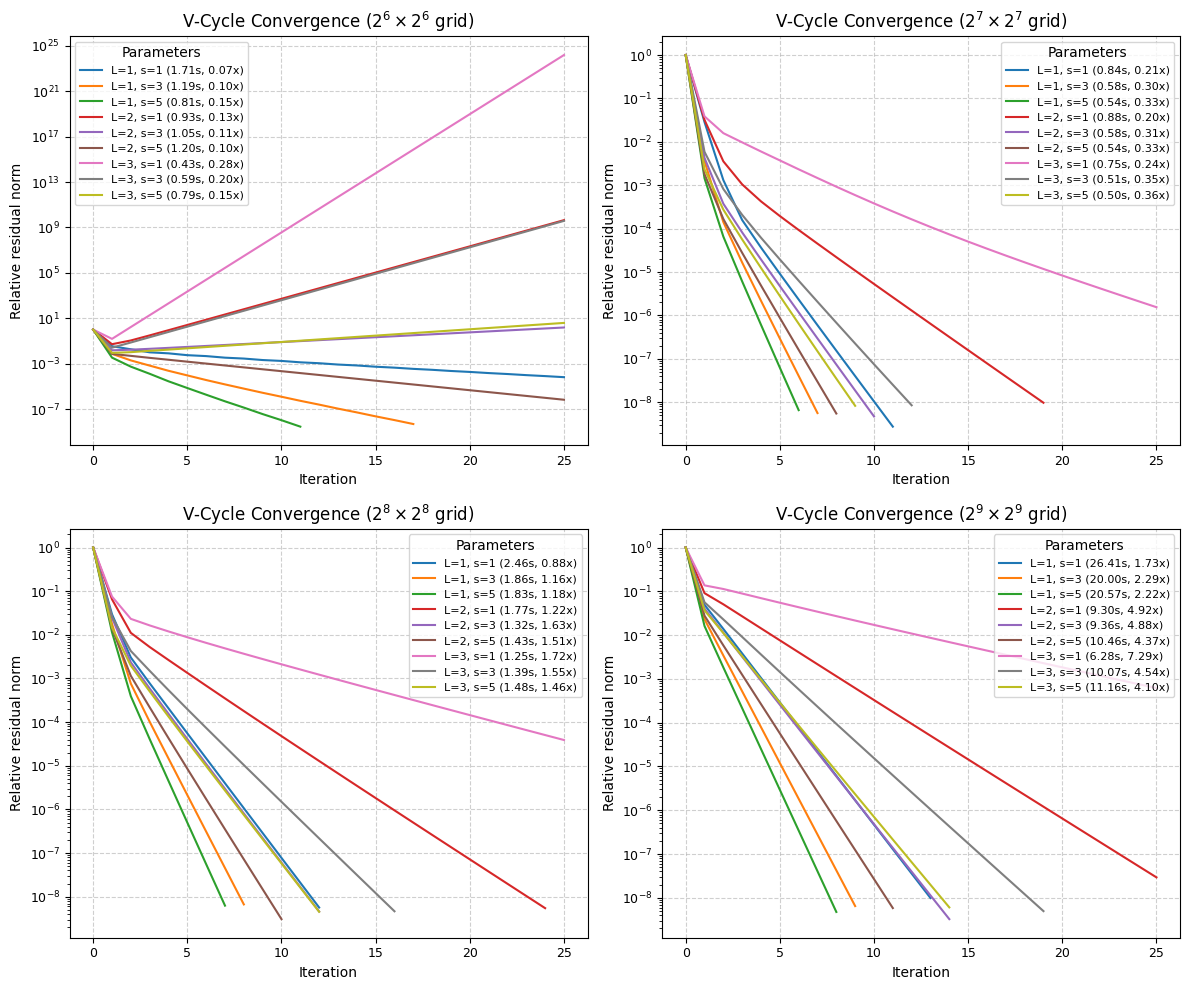

In [12]:
plot_VC_results(
    VC_results,
    cg_results,
    k_list=k_list,
    mycolorwheel=mycolorwheel,
    mycomputeColor=mycomputeColor,
    title_prefix="V-Cycle"
)


$L$ referes to the max level, $s$ the number of smoothening steps, and inside the parenthesis we have the real world time to compute, and the speed-up compared to the same computation using CG.

From our tests, we see that increasing the number of smoothing steps increases convergence rate. However it also increases the computation time per iteration, so it is not necessarily better to use more smoothing steps. Moreover, we see a similar trend for the levels. More levels give a better convergence rate, but also increase computation time per iteration. Both these results are as expected, since fewer levels mean a finer grid, and therefore more similar to the original problem. The smoothing steps are also another projection method, and thus running more steps would be similar to just running red-black Gauss-Seidel itself. So it makes sense that this would increase convergence but also computation time.

We also see that increasing $k$ will decrease convergence rate and increase computation time per iteration, since the dimension of the problem increases. For a small enough $k$, the method does however not converge if the number of levels is too high or the number of smoothing steps too low. We see that running with max level of 3 the iterations actually increase the residual $k=6$. This may be because the last level is too course to accurately give a good approximation. We see that the last level is of image size $2^3 \times 2^3$, i.e. $64$ nodes, compared to the original $64 \times 64$ image with $4096$ pixel values. This grid is thus too course to give a good approximation, at least for the amount of smoothing steps we use.

(HAVEDONE?: Kommenter resultatene over. Skriv noe om at ikke alle konvergerer, så det gir ikke mening å sammenlikne med CG. Introduser det under)

In [13]:
reg_list = [0.5, 1, 10, 1000]
sigma = 0.5

Ix, Iy, rhsu, rhsv = preprocess_images(I1, I2, sigma=sigma)
u0 = np.zeros_like(Ix)
v0 = np.zeros_like(Ix)

VC_results_image = {}

for reg in reg_list:
    start_time = time.time()
    u_VC, v_VC, res_list = V_cycle_iterative(u0, v0, Ix, Iy, reg, rhsu, rhsv,
                              s1=5, s2=5, max_level=1, max_iter=75)

    elapsed_time = time.time() - start_time
    VC_results_image[reg] = {
        "u": u_VC,
        "v": v_VC,
        "iters": len(res_list),
        "residuals": np.array(res_list),
        "time": elapsed_time
    }


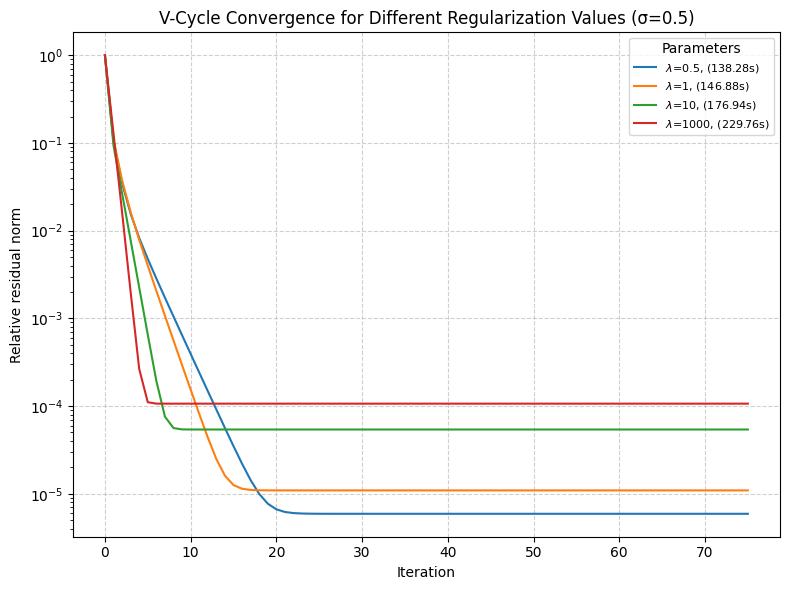

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_VC_results_image(VC_results_image, title_prefix="V-Cycle", sigma=None):
    """
    Plot residual convergence curves for different regularization values.

    Parameters
    ----------
    VC_results_image : dict
        Dictionary with structure:
            VC_results_image[reg] = {
                'residuals': np.array,
                'time': float,
                ...
            }
    title_prefix : str, optional
        Prefix for plot title (default: "V-Cycle").
    sigma : float, optional
        If provided, adds sigma info to the plot title.
    """

    plt.figure(figsize=(8, 6))

    for reg, data in sorted(VC_results_image.items(), key=lambda x: x[0]):
        residuals = np.array(data["residuals"])
        t = data["time"]
        plt.semilogy(
            residuals,
            label=f"$\\lambda$={reg:g}, ({t:.2f}s)"
        )

    plt.xlabel("Iteration")
    plt.ylabel("Relative residual norm")
    title = f"{title_prefix} Convergence for Different Regularization Values"
    if sigma is not None:
        title += f" (σ={sigma})"
    plt.title(title)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend(title="Parameters", fontsize=8)
    plt.tight_layout()
    plt.show()

plot_VC_results_image(VC_results_image, title_prefix="V-Cycle", sigma=sigma)


(TODO: Kommenter resultatene over)

From the plot above, we see that the convergence of V-cycle depends heavily on the choice of the regularization parameter $\lambda$. Particularly, we notice that the convergence rate initially looks faster for the higher values of $\lambda$, but then they begin to stagnate. This can be because the initial image is more similar to the solution in that the zero matrix is smooth everywhere. Thus 

# Problem 4 - Preconditioned Conjugate Gradient

To speed up our approximation while still maintaining accuracy, we will precondition the conjugate gradient method using the V-cycle as a preconditioner. This is one implementation of the Preconditioned Conjugate Gradient (PCG) method, as described in Saad, chapter 9.2.1, algorithm 9.1. Note that we need to preserve symmetry (Saad, chapter 9.2.1), and thus we need to modify the smoother in V-cycle slightly. The preconditioner for Gauss-Seidel is given by $M_{GS}=I-(D-E)^{-1}A$ as described in Saad, equation 10.6. To make the preconditioner symmetric, we will instead use a forward sweep followed by a backward sweep, like we do for symmetric Gauss-Seidel. From Saad, equation 10.9 we see that the precondtioner for symmetric Gauss-Seidel is given by $M_{SGS}=(D-E)D^{-1}(D-F)$, which is symmetric since $A$ is symmetric and thus $E=F$.

Since this is just a forward sweep followed by a backward sweep, we can implement this by first updating the red nodes, then the black nodes, then the black nodes again, and finally the red nodes again. This is essentially iterating in the order "red-black-black-red".

We first run the code for the generated images, using test case 2, with different max levels, image sizes $k$, and numbers of smoothing steps. Note that we vary the pre- and post-smoothing equally.  

In [15]:
max_level_list = [1, 2, 3]
s_list = [1, 3, 5]
PCG_results = {}

for k in k_list:
    image1, image2 = generate_test_image(2**k, testcase=2)
    Ix, Iy, rhsu, rhsv = preprocess_images(image1, image2, sigma=0)
    u0 = np.zeros_like(Ix)
    v0 = np.zeros_like(Ix)
    reg = 4**(k - 4)

    PCG_results[k] = {}

    for max_level in max_level_list:
        PCG_results[k][max_level] = {}

        for s in s_list:
            start_time = time.time()
            u_pcg, v_pcg, pcg_iter, pcg_residuals = OF_Pcg(
                u0, v0, Ix, Iy, reg, rhsu, rhsv,
                max_level=max_level, s1=s, s2=s, tol=1e-8, maxit=60
            )
            elapsed_time = time.time() - start_time

            u_cg = cg_results[k]["u"]
            v_cg = cg_results[k]["v"]

            PCG_results[k][max_level][s] = {
                "u": u_pcg,
                "v": v_pcg,
                "time": elapsed_time,
                "iterations": pcg_iter,
                "residuals": pcg_residuals
            }


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_PCG_results(PCG_results, cg_results, k_list, mycolorwheel=None, mycomputeColor=None, title_prefix="PCG"):
    """
    Plot Preconditioned Conjugate Gradient (PCG) residual convergence results.

    Parameters
    ----------
    PCG_results : dict
        Nested dictionary:
            PCG_results[k][max_level][s] = {
                'u': np.array,
                'v': np.array,
                'time': float,
                'iterations': int,
                'residuals': list or np.array
            }
    k_list : list
        List of grid size exponents (e.g. [4, 5, 6, 7]).
    mycolorwheel : function, optional
        Included for API consistency (unused here).
    mycomputeColor : function, optional
        Included for API consistency (unused here).
    title_prefix : str, optional
        Prefix for the plot titles (default = "PCG").
    """

    nplots = len(k_list)
    nrows, ncols = 2, 2
    fig, axes = plt.subplots(nrows, ncols, figsize=(12, 10))
    axes = axes.ravel()

    for i, k in enumerate(k_list):
        ax = axes[i]
        for max_level in sorted(PCG_results[k].keys()):
            for s in sorted(PCG_results[k][max_level].keys()):
                data = PCG_results[k][max_level][s]
                cg_t = cg_results[k]["time"] 
                residuals = np.array(data["residuals"])
                t = data["time"]
                iters = data["iterations"]

                ax.semilogy(
                    residuals,
                    label=f"L={max_level}, s={s} ({t:.2f}s, {cg_t/t:.1f}x)"
                )

        ax.set_xlabel("Iteration")
        ax.set_ylabel("Relative residual norm")
        ax.set_title(f"{title_prefix} ($2^{k} \\times 2^{k}$ grid)")
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(title="Parameters", fontsize=8)
        ax.tick_params(axis='both', labelsize=9)

    # Hide extra subplots if fewer than 4
    for j in range(i + 1, nrows * ncols):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()


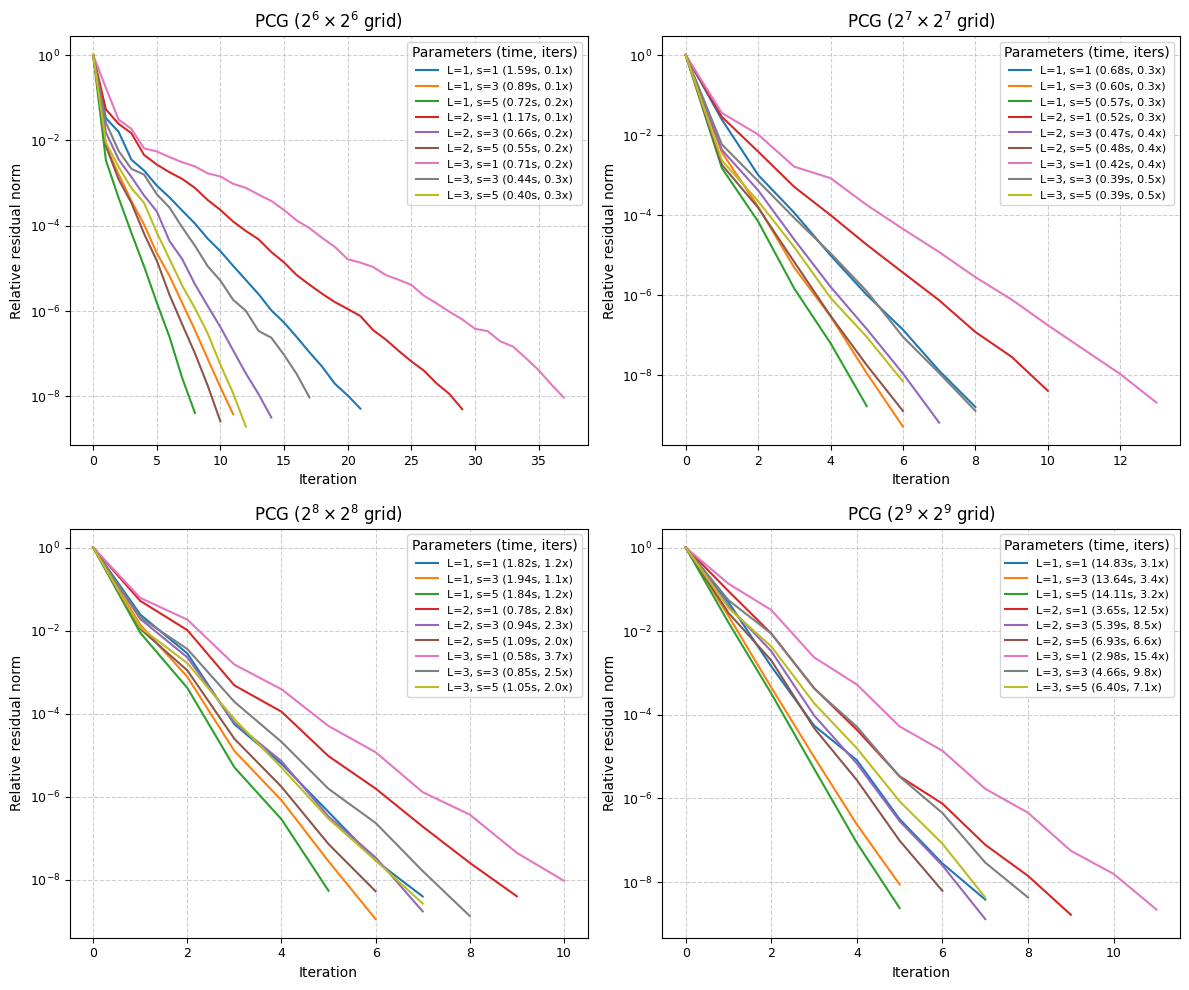

In [17]:
plot_PCG_results(
    PCG_results,
    cg_results,
    k_list=k_list,
    mycolorwheel=mycolorwheel,
    mycomputeColor=mycomputeColor,
    title_prefix="PCG"
)


(TODO: Skriv om dette. Vi endra en del ting)

We observe that for all k and max levels, that with no smoothening steps, the residuals do not decrease much. If we increase the smoothening to 1, 3 and 5, we observe fast convergence in residual error. At a max level of 3, we observe that smoothing is even more important.

The table shows the results for the different parameters. For $k=6,7$, we do not gain any speed up using the preconditioner. For $k=8,9$ we observe a significant time speed-up by using a preconditoner, with max level greater than one. Especially $k=9$, $1$ smoothing step, and max level at two achieves a great speed up.


We test the PCG method on real-life images, using a V-cycle preconditioner with max level of 2, and 3 pre- and post-smoothing steps. 

In [18]:
I1 = plt.imread('Images/frame10.png')
I2 = plt.imread('Images/frame11.png')

Ix, Iy, rhsu, rhsv = preprocess_images(I1, I2, sigma=sigma)
u0 = np.zeros_like(Ix)
v0 = np.zeros_like(Ix)

pcg_results_image = {}

for reg in reg_list:
    start_time = time.time()
    u_pcg, v_pcg, pcg_iter, pcg_residuals = OF_Pcg(
        u0, v0, Ix, Iy, reg, rhsu, rhsv,
        max_level=2, s1=3, s2=3,
        tol=1e-8, maxit=200
    )
    elapsed_time = time.time() - start_time
    u_cg = cg_results_image[reg]["u"]
    v_cg = cg_results_image[reg]["v"]

    pcg_results_image[reg] = {
        "u": u_pcg,
        "v": v_pcg,
        "iters": pcg_iter,
        "residuals": np.array(pcg_residuals),
        "time": elapsed_time,
    }

In [ ]:

def plot_pcg_results_image(cg_results, pcg_results, reg_list, title_prefix="PCG"):
    """
    Plot residual convergence for PCG and show a comparison table vs CG.

    Parameters
    ----------
    cg_results : dict
        Dictionary containing CG results for each λ value.
        Must include keys: 'iters', 'time', 'u', 'v'.
    pcg_results : dict
        Dictionary containing PCG results for each λ value.
        Must include keys: 'iters', 'time', 'error', 'residuals'.
    reg_list : list
        List of regularization parameters (λ values).
    title_prefix : str, optional
        Title prefix for labeling plots and tables (default "PCG").
    """

    # --- Plot Residual Convergence ---
    plt.figure(figsize=(8, 6))
    for reg in reg_list:
        r = np.array(pcg_results[reg]["residuals"])
        t = pcg_results[reg]["time"]
        su = cg_results[reg]["time"]/t
        plt.semilogy(r, lw=2, label=f"$\\lambda$={reg} ({t:.2f}s, {su:.2f}x)")

    plt.xlabel("Iteration")
    plt.ylabel("Relative residual norm")
    plt.title(f"Residual Convergence ({title_prefix})")
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend(title_prefix="Parameters", fontsize=8)
    plt.tight_layout()
    plt.show()


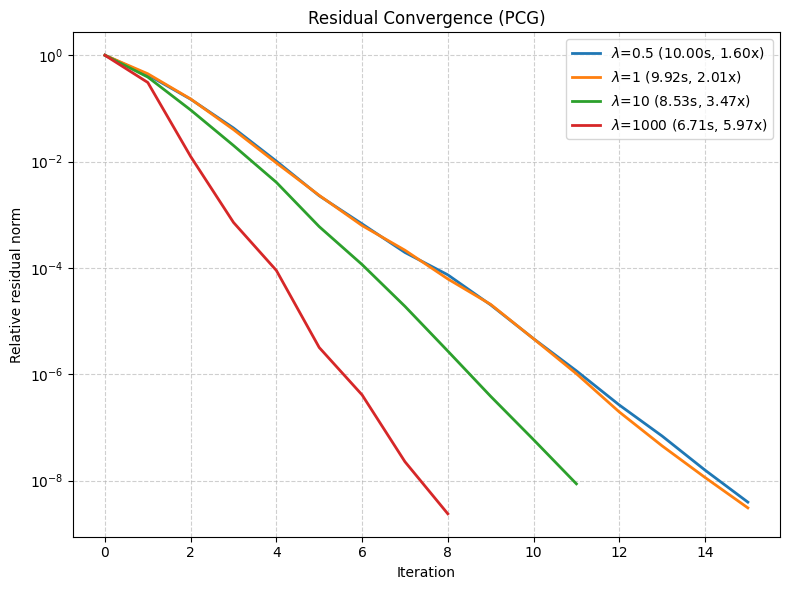

In [20]:
plot_pcg_results_image(cg_results_image, pcg_results_image, reg_list)

(TODO: Rewrite, results have changed)

We observe a fast convergence for each $\lambda$, and the table shows a significant speed up $\lambda=10,1000$, while $\lambda=0.5,1$ shows little difference.